In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118  # Cambiar cu118 por la versión de Cuda del sistema
!pip install ipywidgets widgetsnbextension torchsummary einops tqdm matplotlib
!pip install -U "jax[cuda12]"  # Cambiar cuda11 por la versión de nuestro CUDA
!pip install flax
!pip install -q clu

# PRÁCTICA 7: FINE TUNING

En esta práctica vamos a aprener una de las técnincas más útiles en el entrenamiento de redes neuronales conocida como **fine tuning**. Esta técnica permite aprovechar una reed previamente entrenada en un conjunton de datos para refiniarla hacia un nuevo conjunto y mejorar la capacidad de predicción de la misma en nuevos datos.

A la hora de re-entrenar nuestra red, es posible determinar si queremos refinar todas las capas de la misma o "congelar" parte de estas capas, impidiendo que los optimizadores puedan modificar el estado de las mismas. Esto es especialmente útil en las primeras capas de la red, ya que suelen estar asociadas con características generales que pueden ser fácilmente interpolables a diferentes tipos de datos.

A modo de ejemplo, vamos a utilizar una arquitectura de red muy conocida llamada ``VGG16``, la cual ha sido entrenada con el conjunto ``ImageNet``. Este conjunto contiene alrededor de 14 millones de imágenes anotadas y pertenecientes a diferentes clases de objetos. Esto permite que nuestra red preentrenada tenga una gran capacidad de predicción, puediendo aprovehcar los parámetros de sus capas en nuestros conjuntos de datos.

Vamos a comenzar importando las librerías que usaremos durante la práctica:

In [1]:
!jupyter nbextension enable --py widgetsnbextension

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
import os
import random

# Librerías de PyTorch
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Torch summary para hacer comprobacionesde la red
from torchsummary import summary

# Torch vision para descargar y preprocesar el conjunto de datos que usaremos para entrenar la red
import torchvision
from torchvision import transforms
from torchvision.datasets import FashionMNIST
import torchvision.models as models

# Herramientas adicionales para la visualización de los datos y resultados
from PIL import Image
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

Durante esta práctica usaremos de nuevo el conjunto de datos `FashionMNIST` para entrenar la red. Comenzaremos por descargar y generar el `DataLoader` para poder enviar datos a la red de manera eficiente:

In [3]:
def collate_fn(batch):
    process = transforms.Compose([
                transforms.ToTensor(),
                transforms.Pad([2])]
                )

    # x - imágenes; procesamos cada imagen en el lote
    x = [process(data[0].convert('RGB')) for data in batch]
    x = torch.stack(x, dim=0)

    # y - labels, hay que convertirlos al tipo LongTensor
    y = torch.LongTensor([data[1] for data in batch])

    return x, y

config = {
    "batch_size": 64,
    "epochs": 3,
    "lr": 1e-4,   # learning rate
}

labels = ["Camiseta",
          "Vaqueros",
          "Jersey",
          "Vestido",
          "Abrigo",
          "Sandalia",
          "Falda",
          "Deportiva",
          "Bolso",
          "Zapato"]

# Para una ejecución más rápida
torch.set_float32_matmul_precision('high')
torch.backends.cudnn.benchmark = True

# Descarga de los datos
train_data = FashionMNIST("./MNIST_DATA", train=True, download=True)
valid_data = FashionMNIST("./MNIST_DATA", train=False, download=True)

# Generamos los DataLoader
train_loader = DataLoader(train_data, batch_size=config["batch_size"],
                          shuffle=True, collate_fn=collate_fn, num_workers=4)
valid_loader = DataLoader(valid_data, batch_size=64,
                           shuffle=False, collate_fn=collate_fn, num_workers=4)

También podemos aprovechar para visualizar los datos como hemos hecho en prácticas anteriores:

Inspección de los datos de entrenamiento: 
Tamaño del lote:  torch.Size([64, 3, 32, 32])


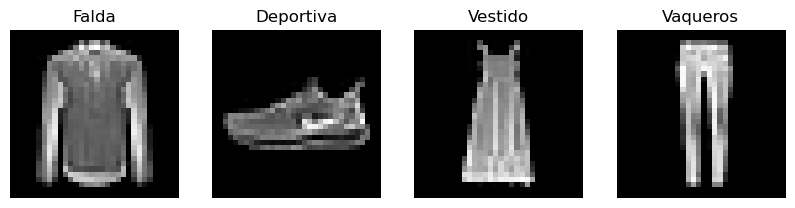

In [4]:
print("Inspección de los datos de entrenamiento: ")
for _, data in enumerate(train_loader):
    print("Tamaño del lote: ", data[0].shape)
    fig, ax = plt.subplots(1, 4, figsize=(10, 4))

    for i in range(4):
        x = torch.norm(data[0], dim=1)
        ax[i].imshow(x[i], cmap="gray")
        ax[i].axis("off")
        ax[i].set_title(labels[data[1][i]])
    plt.show()
    # Usamos break para no recorrer todo el DataLoader
    break

El siguiente paso consiste en definir nuestra red pre-entrenada ``VGG16``. La mayoría de librerías de deep learning (Tensorflow, PyTorch, JAX...) incluyen métodos para descargar redes populares pre-entrenadas en conjuntos de datos. De esta manera se simplifica en gran medida el acceso a estas redes y su aprovechamiento en nuestros proyectos:

In [5]:
# Descargamos nuestro modelo VGG16 pre-entrenado
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

# Arquitectura del modelo
summary(vgg16.cuda(), input_size=(3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

Inspeccionando el resumen del modelo, podemos darnos cuenta de lo siguiente:
- El tamaño de entreda del modelo son, por defecto, imágenes con un tamaño de caja de 224 pixeles (y tamaño mínimo de 32). Tendremos que tener en cuenta este tamaño y asegurarnos que nuestros datos lo respetan.
- La última capa de la red es una capa lineal de tamaño 1000. Este sería el número total de clases en el conjunto original de ``ImageNet``. Esta capa suele ser uno de los principales candidatos a re-entrenar en nuevos conjuntos de datos.
- La red tiene todos sus parámetros marcados como "entrenables". Si no modificamos este estado, todas las capas serán refinadas con nuestro nuevo conjunto de datos.

A modo de ejemplo, vamos a aprovechar esta red para definir un **Autoencoder** similar al que entrenamos en las Prácticas 2 y 3. Para ello, aprovecharemos nuestra ``VGG16`` a modo de ``Enocder``, y definiremos nuestro ``Decoder`` para que sea similar al de las Prácticas 2 y 3.

Vamos a comenzar modificando nuestra ``VGG16`` para que tenga una última capa de espacio latente, así como modificar el estado del resto de capas convolucionales para que no sean entrenables:

In [6]:
# Primero modificamos la última capa del clasificador (capas densas) para que genere un espacio 2D en la salida
vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=2)

# A continuación congelamos todas las capas que no pertenezcan al clasificador para impedir que puedan ser entrenadas
for param in vgg16.parameters():
    param.requires_grad = False
for param in vgg16.classifier.parameters():
    param.requires_grad = True

summary(vgg16.cuda(), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

En el nuevo resumen del modelo, podemos ver que la última capa del clasificador generará un espacio de salida 2D. También podemos observar que el número de parámetros no entrenables ha dejado de ser cero, indicando que hay capas congeladas cuyo estado no será modificado por nuestro optimizador.

Vamos a coninuar definiendo nuestro ``Decoder``. En primer lugar, definiremos una seria de atributos que serán de utilidad para definir las capas de nuestra red:

In [7]:
# Model parameters:
LAYERS = 3  # Cantidad de capas en la red
KERNELS = [3, 3, 3]  # Tamaño del kernel de convolución (uno para cada capa)
CHANNELS = [32, 64, 128]  # Cantidad de canales/filtros que se calcularán en cada capa
STRIDES = [2, 2, 2]  # Parámetro que determina el movimiento del filtro a través de los datos de entrada. Al realizar una operación de convolución, este parámetros determina cuántas unidades se desplaza el filtro en cada paso. Este desplazamiento puede ser horizontal, vertical o ambos, según su configuración.
LINEAR_DIM = 2048  # Tamaño de las capas densas (el número de neuronas de cada capa densa)

Y continuamos definiendo el ``Decoder``:

In [8]:
class Decoder(nn.Module):

    def __init__(self, input_dim=2, use_batchnorm=False, use_dropout=False):

        super(Decoder, self).__init__()

        # Variables que determinan si se usan capas de dropout y de normalización de lotes
        self.use_dropout = use_dropout
        self.use_batchnorm = use_batchnorm

        self.fc_dim = LINEAR_DIM
        self.input_dim = input_dim

        # Hyperparámetros de las capas convolucionales
        self.layers = LAYERS
        self.kernels = KERNELS
        self.channels = CHANNELS[::-1] # flip the channel dimensions
        self.strides = STRIDES

        # Al ser un espejo de la red de codificación, primero usaremos capas densas y luego convolucionales transpuestas
        self.linear = nn.Linear(self.input_dim, self.fc_dim)
        self.conv =  self.get_convs()

        self.output = nn.Conv2d(self.channels[-1], 3, kernel_size=1, stride=1)

    def get_convs(self):
        conv_layers = nn.Sequential()
        for i in range(self.layers):

            if i == 0: conv_layers.append(
                            nn.ConvTranspose2d(self.channels[i],
                                               self.channels[i],
                                               kernel_size=self.kernels[i],
                                               stride=self.strides[i],
                                               padding=1,
                                               output_padding=1)
                            )

            else: conv_layers.append(
                            nn.ConvTranspose2d(self.channels[i-1],
                                               self.channels[i],
                                               kernel_size=self.kernels[i],
                                               stride=self.strides[i],
                                               padding=1,
                                               output_padding=1
                                              )
                            )

            if self.use_batchnorm and i != self.layers - 1:
                conv_layers.append(nn.BatchNorm2d(self.channels[i]))

            conv_layers.append(nn.ReLU())

            if self.use_dropout:
                conv_layers.append(nn.Dropout2d(0.15))

        return conv_layers


    def forward(self, x):
        x = self.linear(x)
        # reshape 3D tensor to 4D tensor
        x = x.reshape(x.shape[0], 128, 4, 4)
        x = self.conv(x)
        x = self.output(x)
        return x

summary(Decoder().cuda(), input_size=(2, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]           6,144
   ConvTranspose2d-2            [-1, 128, 8, 8]         147,584
              ReLU-3            [-1, 128, 8, 8]               0
   ConvTranspose2d-4           [-1, 64, 16, 16]          73,792
              ReLU-5           [-1, 64, 16, 16]               0
   ConvTranspose2d-6           [-1, 32, 32, 32]          18,464
              ReLU-7           [-1, 32, 32, 32]               0
            Conv2d-8            [-1, 3, 32, 32]              99
Total params: 246,083
Trainable params: 246,083
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.91
Params size (MB): 0.94
Estimated Total Size (MB): 1.85
----------------------------------------------------------------


Por último, definimos una clase auxiliar ``Autoencoder`` para simplificar el manejo de nuestra red:

In [9]:
class AutoEncoder(nn.Module):

    def __init__(self, encoder: nn.Module):
        super(AutoEncoder, self).__init__()
        self.encoder = encoder
        self.decoder = Decoder(input_dim=2,
                               use_batchnorm=True, use_dropout=False)

    def forward(self, x):
        return self.decoder(self.encoder(x))

model = AutoEncoder(encoder=vgg16)
model = torch.compile(model, mode='reduce-overhead')
model.cuda()

OptimizedModule(
  (_orig_mod): AutoEncoder(
    (encoder): VGG(
      (features): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace=True)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace=True)
        (14): Conv2d(256, 256, kernel_size=(3, 3), st

Una vez definido nuestro autoencoder, podemos empezar a escribir nuestro loop de entrenamiento. Sin embargo, antes de hablar sobre el entrenamiento, vamos a definir una serie de funciones para representar el espacio latente codificado a medida que entrenamos, para así poder comprender como la red neuronal aprende de manera progresiva a clasificar nuestro datos:

In [10]:
def plotting(step:int=0, show=False):

    model.eval()  # Pasamos el modelo a modo evaluación (en este modo, las capas de Dropout y BatchNorm se desactivan para mejorar la precisión de las predicciones)

    points = []
    label_idcs = []

    path = "./ScatterPlots_FineTune"
    if not os.path.exists(path): os.mkdir(path)

    for i, data in enumerate(valid_loader):
        if i % 5 == 0:
            img, label = [d for d in data]
            # Solo necesitamos codificar las imágenes
            with torch.no_grad():
                proj = model.encoder(img.cuda())
            points.extend(proj.cpu().numpy())
            label_idcs.extend(label.numpy())
            del img, label

    points = np.array(points)

    # Creamos nuestra gráfica
    fig, ax = plt.subplots(figsize=(10, 10) if not show else (8, 8))
    scatter = ax.scatter(x=points[:, 0], y=points[:, 1], s=5.0,
                c=label_idcs, cmap='tab10', alpha=0.9, zorder=2)
    plt.title("Step {}".format(step))
    handles, _ = scatter.legend_elements()
    plt.legend(handles=handles, labels=labels)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    if show:
        ax.grid(True, color="lightgray", alpha=1.0, zorder=0)
        plt.show()
    else:
        # Aqui guardamos la gráfica actual
        plt.savefig(f"{path}/Step_{step:04d}.png", bbox_inches="tight")
        plt.close() # Es importante no olvidarse de cerrar la figura para que no se quede cargada en memoria
        model.train()

# Conversión de las gráficas a un formato GIF
def save_gif():

  frames = []
  imgs = sorted(os.listdir("./ScatterPlots_FineTune"))

  for im in imgs:
      new_frame = Image.open("./ScatterPlots_FineTune/" + im)
      frames.append(new_frame)

  frames[0].save("latentspace_FineTune.gif", format="GIF",
                 append_images=frames[1:],
                 save_all=True,
                 duration=200, loop=0)

Antes de definir el loop de entrenamiento, vamos a definir unas variables de configuración y el optimizador para poder usarlas durante el entrenamiento:

In [11]:
criterion = nn.MSELoss()  # Usaremos como función de péridida el error cuadrático medio
optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=1e-5)

# For mixed precision training
scaler = torch.amp.GradScaler("cuda")  # Para poder hacer mixed precision training (explicación en la siguiente celda)
steps = 0  # Variable para contar el número de steps/lotes que ha ido viendo la red

A continuación vamos a deifinir el loop de entraniento. Para tener el código más ordenado, definiremos dos funciones:
   - **Función "train"**: Contiene toda la lógica necesaria para entrenar el modelo durante una epoch completa
   - **Función "validate"**: Contiene toda la lógica para evaluar el módelo en un conjunto de datos (pero sin actualizar los parámetros de la red con estos datos)

In [12]:
def train(model, dataloader, criterion, optimizer, save_distrib=False):
    # Esta variable solo la usamos para hacer un seguimiento del entrenamiento y poder guardar los espacios latentes
    global steps

    model.train()
    train_loss = 0.0

    # Barra de progreso
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True,
                     leave=False, position=0, desc="Train")

    for i, batch in enumerate(dataloader):

        optimizer.zero_grad()
        x = batch[0].cuda()

        with torch.amp.autocast("cuda"):
            y_recons = model(x)
            loss = criterion(y_recons, x)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()

        batch_bar.set_postfix(
            loss=f"{train_loss/(i+1):.4f}",
            lr = f"{optimizer.param_groups[0]['lr']:.4f}"
        )
        batch_bar.update()

        # Guardamos el estado del espacio latente para su posterior visualización
        if steps % 10 == 0 and save_distrib and steps <= 400: plotting(steps)
        if steps % 100 == 0 and save_distrib and steps >= 500 and steps <= 3000: plotting(steps)
        steps += 1

        # Eliminamos el cache no necesario de la GPU para ahorrar memoriar
        torch.cuda.empty_cache()
        del x, y_recons

    batch_bar.close()
    train_loss /= len(dataloader)

    return train_loss


def validate(model, dataloader, criterion):

    model.eval()  # Usamos el modelo en modo evaluación (capas de Dropout y BatchNorm desactivadas)
    valid_loss = 0.0

    # Barra de progreso
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True,
                     leave=False, position=0, desc="Validation")

    for i, batch in enumerate(dataloader):
        x = batch[0].cuda()

        with torch.no_grad():  # No necesitamos los gradientes en la validación
            y_recons = model(x)
            loss = criterion(y_recons, x)

        valid_loss += loss.item()

        batch_bar.set_postfix(
            loss=f"{valid_loss/(i+1):.4f}",
            lr = f"{optimizer.param_groups[0]['lr']:.4f}"
        )
        batch_bar.update()

        torch.cuda.empty_cache()
        del x, y_recons

    batch_bar.close()
    valid_loss /= len(dataloader)

    return valid_loss

A continuación definimos el loop de entrenamiento y entrenamos nuestra red neuronal:

In [13]:
for i in range(config["epochs"]):

    curr_lr = float(optimizer.param_groups[0]["lr"])
    train_loss = train(model, train_loader, criterion,
                       optimizer, save_distrib=True)
    valid_loss = validate(model, valid_loader, criterion)

    print(f"Epoch {i+1}/{config['epochs']}\nTrain loss: {train_loss:.4f}\t Validation loss: {valid_loss:.4f}\tlr: {curr_lr:.4f}")

Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1/3
Train loss: 0.0433	 Validation loss: 0.0301	lr: 0.0001


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/3
Train loss: 0.0300	 Validation loss: 0.0287	lr: 0.0001


Train:   0%|          | 0/938 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/3
Train loss: 0.0289	 Validation loss: 0.0279	lr: 0.0001


Una vez terminado el entrenamiento, podemos visualizar el proceso de optimización del espacio latente:

In [16]:
save_gif()

<img src="latentspace_FineTune.gif" width=500, heigh=500 />

<img src="ScatterPlots_FineTune/Step_2800.png" width=500, heigh=500 />

Por último, podemos seleccionar puntos aleatorios del espacio latente anterior y aprovechar la red de decodificación para comprobar que la red neuronal ha aprendedido correctamente a recuperar los datos de entrada a partir del espacio codificado:

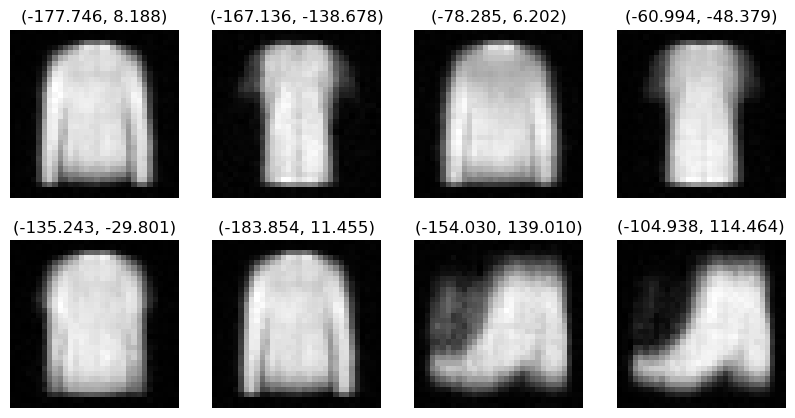

In [17]:
# Muestras aleatorias de puntos en el espacio codificado
xs = [random.uniform(-200.0, 50.0) for i in range(8)]
ys = [random.uniform(-150, 150.0) for i in range(8)]

points = list(zip(xs, ys))
coords = torch.tensor(points).unsqueeze(1).cuda()

nrows, ncols = 2, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 5))

model.eval()
with torch.no_grad():
    generates = [torch.norm(model.decoder(coord), dim=1) for coord in coords]

# Muestra las imágenes decodificadas a partir de los puntos anteriores
idx = 0
for row in range(0, nrows):
    for col in range(0, ncols):
        ax = axes[row, col]
        im = generates[idx].squeeze().detach().cpu()
        ax.imshow(im, cmap="gray")
        ax.axis("off")
        coord = coords[idx].detach().cpu().numpy()[0]
        ax.set_title(f"({coord[0]:.3f}, {coord[1]:.3f})")
        idx += 1

plt.show()